<h2>ML Project 3</h2>


<b>Import Libraries</b>

In [ ]:
from google.colab import files
import pickle

# Upload the file
uploaded = files.upload()

Saving diabetes.pickle to diabetes.pickle
Saving sample.pickle to sample.pickle


In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from math import sqrt, pi
import pickle
import sys
import os

<h3>Problem 1 Function:</h3>

In [ ]:
def ldaLearn(X, y):

    classes = np.unique(y)
    d = X.shape[1]
    k = len(classes)
    means = np.zeros((d, k))

    for i, c in enumerate(classes):
        means[:, i] = np.mean(X[y.flatten() == c], axis=0)

    covmat = np.cov(X, rowvar=False)
    return means, covmat

def qdaLearn(X, y):

    classes = np.unique(y)
    d = X.shape[1]
    k = len(classes)
    means = np.zeros((d, k))
    covmats = []

    for i, c in enumerate(classes):
        class_data = X[y.flatten() == c]
        means[:, i] = np.mean(class_data, axis=0)
        covmats.append(np.cov(class_data, rowvar=False))

    return means, covmats


In [ ]:
def ldaTest(means, covmat, Xtest, ytest):

    inv_covmat = inv(covmat)
    scores = []

    for i in range(means.shape[1]):
        diff = Xtest - means[:, i].T
        scores.append(-0.5 * np.sum(diff @ inv_covmat * diff, axis=1))

    scores = np.array(scores).T
    ypred = np.argmax(scores, axis=1) + 1
    acc = np.mean(ypred.flatten() == ytest.flatten())
    return acc, ypred.reshape(-1, 1)

def qdaTest(means, covmats, Xtest, ytest):

    scores = []

    for i in range(means.shape[1]):
        diff = Xtest - means[:, i].T
        inv_covmat = inv(covmats[i])
        logdet_covmat = np.log(det(covmats[i]))
        scores.append(-0.5 * (np.sum(diff @ inv_covmat * diff, axis=1) + logdet_covmat))

    scores = np.array(scores).T
    ypred = np.argmax(scores, axis=1) + 1
    acc = np.mean(ypred.flatten() == ytest.flatten())
    return acc, ypred.reshape(-1, 1)


<h3>Problem 2 Function:</h3>

In [ ]:
def learnOLERegression(X, y):

    w = inv(X.T @ X) @ X.T @ y
    return w


In [ ]:
def testOLERegression(w, Xtest, ytest):

    ypred = Xtest @ w
    mse = np.mean((ytest - ypred) ** 2)
    return mse

<h3>Problem 3:</h3>

In [ ]:
def learnRidgeRegression(X, y, lambd):
    d = X.shape[1]
    I = np.eye(d)
    w = inv(X.T @ X + lambd * I) @ X.T @ y
    return w

<h3>Problem 4:</h3>

In [ ]:
def regressionObjVal(w, X, y, lambd):
    w = w.reshape(-1, 1)
    error = 0.5 * np.sum((y - X @ w) ** 2) + 0.5 * lambd * np.sum(w ** 2)
    error_grad = -X.T @ (y - X @ w) + lambd * w
    return error, error_grad.flatten()

<h3>Problem 5 </h3>

In [ ]:
def mapNonLinear(x, p):
    # Problem 5 Implementation Starts Here
    N = x.shape[0]
    Xp = np.ones((N, p + 1))
    for i in range(1, p + 1):
        Xp[:, i] = x.flatten() ** i
    return Xp

# Main script
# Load the sample data

In [ ]:
if sys.version_info.major == 2:
    X, y, Xtest, ytest = pickle.load(open('sample.pickle', 'rb'))
else:
    file_path = 'sample.pickle'
    X, y, Xtest, ytest = pickle.load(open(file_path, 'rb'), encoding='latin1')



#Problem 1 Implementation:

In [ ]:
# LDA
means, covmat = ldaLearn(X, y)
ldaacc, lda_res = ldaTest(means, covmat, Xtest, ytest)
print('LDA Accuracy = ' + str(ldaacc))

# QDA
means, covmats = qdaLearn(X, y)
qdaacc, qda_res = qdaTest(means, covmats, Xtest, ytest)
print('QDA Accuracy = ' + str(qdaacc))


LDA Accuracy = 0.97
QDA Accuracy = 0.96


# Load the diabetes data

In [ ]:
if sys.version_info.major == 2:
    X, y, Xtest, ytest = pickle.load(open('diabetes.pickle', 'rb'))
else:
    file_path = 'diabetes.pickle'
    X, y, Xtest, ytest = pickle.load(open(file_path, 'rb'), encoding='latin1')



#Problem 2 Implementation:


In [ ]:
# Add intercept
X_i = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0], 1)), Xtest), axis=1)

# OLE Regression
w = learnOLERegression(X, y)
mse = testOLERegression(w, Xtest, ytest)
print('MSE without intercept: ' + str(mse))

w_i = learnOLERegression(X_i, y)
mse_i = testOLERegression(w_i, Xtest_i, ytest)
print('MSE with intercept: ' + str(mse_i))

MSE without intercept: 106775.36155731279
MSE with intercept: 3707.840181454929


# Problem 3 Implementation Starts Here



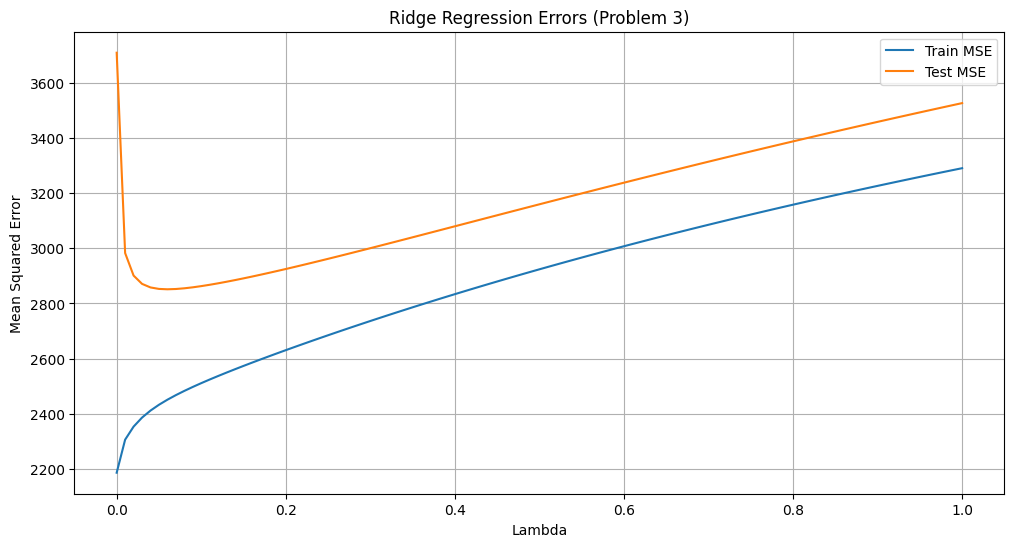

In [ ]:
# Ridge Regression
lambdas = np.linspace(0, 1, 101)
mses_train = []
mses_test = []

for lambd in lambdas:
    w = learnRidgeRegression(X_i, y, lambd)
    mses_train.append(testOLERegression(w, X_i, y))
    mses_test.append(testOLERegression(w, Xtest_i, ytest))

# Plot errors for Ridge Regression (Problem 3)
plt.figure(figsize=[12, 6])
plt.plot(lambdas, mses_train, label='Train MSE')
plt.plot(lambdas, mses_test, label='Test MSE')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression Errors (Problem 3)')
plt.legend()
plt.grid()
plt.show()

# Problem 4 Implementation Starts Here
# Gradient Descent for Ridge Regression

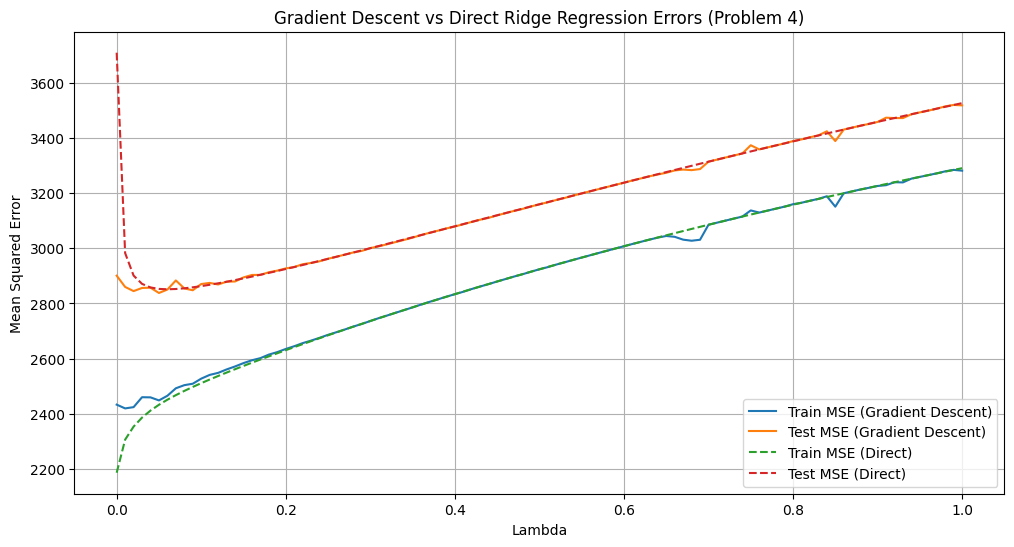

In [ ]:
mses4_train = []
mses4_test = []
opts = {'maxiter': 20}  # Adjust maximum iterations for gradient descent
w_init = np.ones(X_i.shape[1])  # Use 1D array for the initial guess

for lambd in lambdas:
    args = (X_i, y, lambd)
    result = minimize(regressionObjVal, w_init, jac=True, args=args, method='CG', options=opts)
    w_l = result.x.reshape(-1, 1)  # Reshape back to 2D for further calculations
    mses4_train.append(testOLERegression(w_l, X_i, y))
    mses4_test.append(testOLERegression(w_l, Xtest_i, ytest))

# Plot errors for Gradient Descent Ridge Regression (Problem 4)
plt.figure(figsize=[12, 6])
plt.plot(lambdas, mses4_train, label='Train MSE (Gradient Descent)')
plt.plot(lambdas, mses4_test, label='Test MSE (Gradient Descent)')
plt.plot(lambdas, mses_train, '--', label='Train MSE (Direct)')
plt.plot(lambdas, mses_test, '--', label='Test MSE (Direct)')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Gradient Descent vs Direct Ridge Regression Errors (Problem 4)')
plt.legend()
plt.grid()
plt.show()


# Problem 5 Implementation:
<h3> Non-linear Regression with Optimal Lambda</h3>

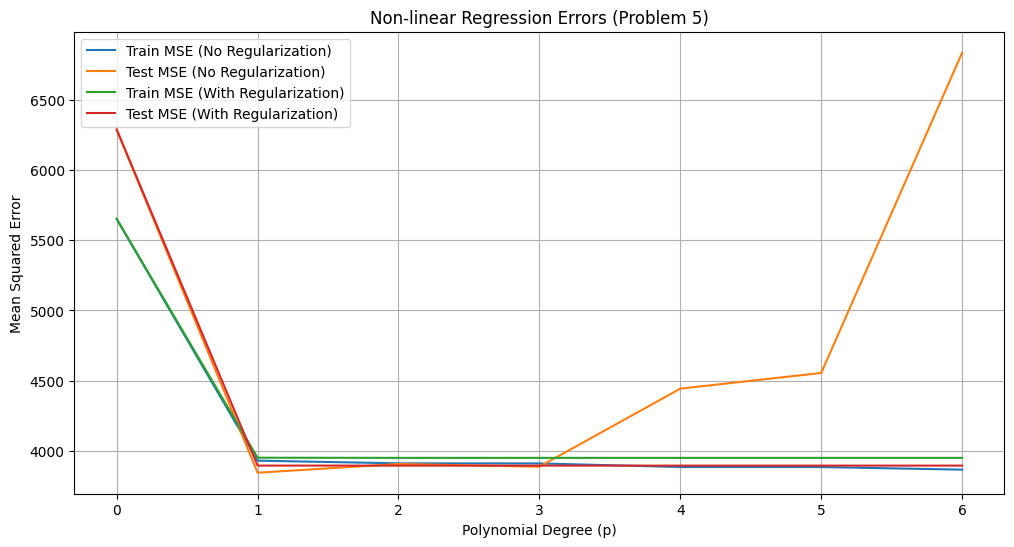

In [ ]:
optimal_lambda = lambdas[np.argmin(mses_test)]  # Use the lambda with the lowest test error
pmax = 7
mses5_train = np.zeros((pmax, 2))
mses5_test = np.zeros((pmax, 2))

for p in range(pmax):
    Xd = mapNonLinear(X[:, 2], p)
    Xdtest = mapNonLinear(Xtest[:, 2], p)

    # Without Regularization
    w_no_reg = learnRidgeRegression(Xd, y, 0)
    mses5_train[p, 0] = testOLERegression(w_no_reg, Xd, y)
    mses5_test[p, 0] = testOLERegression(w_no_reg, Xdtest, ytest)

    # With Regularization
    w_reg = learnRidgeRegression(Xd, y, optimal_lambda)
    mses5_train[p, 1] = testOLERegression(w_reg, Xd, y)
    mses5_test[p, 1] = testOLERegression(w_reg, Xdtest, ytest)

# Plot errors for Non-linear Regression
plt.figure(figsize=[12, 6])
plt.plot(range(pmax), mses5_train[:, 0], label='Train MSE (No Regularization)')
plt.plot(range(pmax), mses5_test[:, 0], label='Test MSE (No Regularization)')
plt.plot(range(pmax), mses5_train[:, 1], label='Train MSE (With Regularization)')
plt.plot(range(pmax), mses5_test[:, 1], label='Test MSE (With Regularization)')
plt.xlabel('Polynomial Degree (p)')
plt.ylabel('Mean Squared Error')
plt.title('Non-linear Regression Errors (Problem 5)')
plt.legend()
plt.grid()
plt.show()